In [75]:
import torch
import numpy as np
import random
import matplotlib.pyplot as plt 
from torch.nn import Module, Linear, ReLU

In [76]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last"

In [77]:
class ContextBandit: # 강화학습을 위한 시뮬레이션 환경 구축
    
    def __init__(self, arms=10):
        self.arms = arms
        self.init_distribution(arms)
        self.update_state()
    
    def init_distribution(self, arms):
        self.bandit_matrix = np.random.rand(arms,arms)
        
    def reward(self, prob):
        reward = 0
        for i in range(self.arms):
            reward += 1 if random.random() < prob else 0
        return reward
    
    def get_state(self):
        return self.state
    
    def update_state(self):
        self.state = np.random.randint(0,self.arms)
    
    def get_reward(self, arm):
        return self.reward(self.bandit_matrix[self.get_state()][arm])
    
    def choose_arm(self, arm):
        reward = self.get_reward(arm)
        self.update_state()
        return reward
    

In [78]:
def one_hot(N, pos, val=1):
    one_hot_vec = np.zeros(N)
    one_hot_vec[pos] = val
    return one_hot_vec

def softmax(values, tau=1.12):
    soft = np.exp(values / tau)
    soft /= np.sum(soft)
    return soft

def running_mean(x,N=50):
    c = x.shape[0] - N
    y = np.zeros(c)
    conv = np.ones(N)
    for i in range(c):
        y[i] = (x[i:i+N] @ conv) / N
    return y

In [79]:
arms = 10
(N, D_in, Hidn, D_out) = (1, arms, 100, arms)

model = torch.nn.Sequential(
    Linear(D_in, Hidn), ReLU(),
    Linear(Hidn, D_out), ReLU()
)

env = ContextBandit(arms)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

In [88]:
def train(env, epochs=5000):
    cur_state = torch.Tensor(one_hot(arms,env.get_state())) # 초기 설정
    averages = [0]
    for i in range(epochs):
        y_pred = model(cur_state) # 현재 상태 받아오기
        p = softmax(y_pred.data.numpy()) # 소프트맥스 행동 결정
        choice = np.random.choice(arms, p=p) 
        
        cur_reward = env.choose_arm(choice) # 보상 계산 및 처리
        one_hot_reward = y_pred.data.numpy().copy()
        one_hot_reward[choice] = cur_reward 
        reward = torch.Tensor(one_hot_reward)
        average = ((i+1) * averages[-1] + cur_reward) / (i+2)
        averages.append(average)
        
        loss = loss_fn(y_pred, reward) # 신경망 학습 단계 (optimizer)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        cur_state = torch.Tensor(one_hot(arms, env.get_state()))
        
    return averages

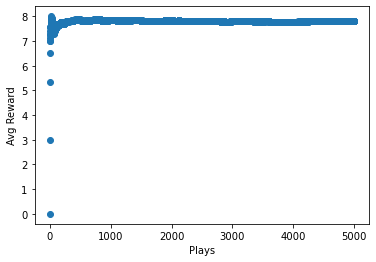

In [89]:
fig, ax = plt.subplots(1,1)
ax.set_xlabel("Plays")
ax.set_ylabel("Avg Reward")
averages = train(env)
ax.scatter(np.arange(len(averages)), averages)